In [8]:
!python -m pip install seaborn matplotlib pandas scikit-learn


In [10]:
import seaborn as sns
print("Seaborn version:", sns.__version__)


ModuleNotFoundError: No module named 'seaborn'

In [21]:
import os
import pickle
import numpy as np
from sklearn.metrics import accuracy_score

from deepface import DeepFace
import face_recognition

# -----------------
# Paths
# -----------------
MAIN_DIR = os.path.abspath("..")   # parent of notebook/

# ArcFace uses dataset/
ARC_DATASET_DIR = os.path.join(MAIN_DIR, "dataset")
# HOG uses dataset12/
HOG_DATASET_DIR = os.path.join(MAIN_DIR, "dataset12")

ARC_PATH = os.path.join(MAIN_DIR, "encodings_arcface.pkl")
HOG_PATH = os.path.join(MAIN_DIR, "encodings_hog.pkl")

# thresholds
ARCFACE_SIM_THRESHOLD = 0.45
HOG_EUCLIDEAN_THRESHOLD = 0.6

# -----------------
# Helpers
# -----------------
def fix_path(img_path, dataset_dir):
    """Try to remap old paths to the right dataset folder."""
    if os.path.exists(img_path):
        return img_path
    fname = os.path.basename(img_path)
    folder = os.path.basename(os.path.dirname(img_path))
    candidate = os.path.join(dataset_dir, folder, fname)
    return candidate if os.path.exists(candidate) else None

def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b) + 1e-6)

# -----------------
# Evaluator
# -----------------
def evaluate_model(enc_path, model_type="ArcFace", dataset_dir=None):
    with open(enc_path, "rb") as f:
        data = pickle.load(f)

    embeddings = np.array(data["embeddings"], dtype=np.float32)
    ids = [str(x).zfill(3) for x in data["ids"]]
    test_records = data["test_records"]

    y_true, y_pred = [], []

    for img_path, _, sid in test_records:
        sid = str(sid).zfill(3)
        img_path = fix_path(img_path, dataset_dir)
        if not img_path:
            continue

        # compute embedding
        if model_type == "ArcFace":
            rep = DeepFace.represent(
                img_path=img_path,
                model_name="ArcFace",
                detector_backend="opencv",
                enforce_detection=False
            )
            if not rep:
                continue
            test_emb = np.array(rep[0]["embedding"], dtype=np.float32)
            sims = [cosine_similarity(e, test_emb) for e in embeddings]
            idx = np.argmax(sims)
            pred_id = ids[idx] if sims[idx] >= ARCFACE_SIM_THRESHOLD else "Unknown"

        elif model_type == "HOG":
            img = face_recognition.load_image_file(img_path)
            encs = face_recognition.face_encodings(img)
            if len(encs) == 0:
                continue
            test_emb = np.array(encs[0], dtype=np.float32)
            dists = np.linalg.norm(embeddings - test_emb, axis=1)
            idx = np.argmin(dists)
            pred_id = ids[idx] if dists[idx] <= HOG_EUCLIDEAN_THRESHOLD else "Unknown"

        else:
            raise ValueError("Model must be ArcFace or HOG")

        y_true.append(sid)
        y_pred.append(pred_id)

    acc = accuracy_score(y_true, y_pred) if y_true else 0
    print(f"{model_type} Accuracy: {acc*100:.2f}% (Processed {len(y_true)} test images)")
    return acc, y_true, y_pred

# -----------------
# Run evaluation
# -----------------
arc_acc, arc_true, arc_pred = evaluate_model(ARC_PATH, "ArcFace", dataset_dir=ARC_DATASET_DIR)
hog_acc, hog_true, hog_pred = evaluate_model(HOG_PATH, "HOG", dataset_dir=HOG_DATASET_DIR)

print("\n=== Accuracy Comparison ===")
print(f"ArcFace: {arc_acc*100:.2f}%")
print(f"HOG: {hog_acc*100:.2f}%")


ArcFace Accuracy: 99.17% (Processed 120 test images)
HOG Accuracy: 100.00% (Processed 97 test images)

=== Accuracy Comparison ===
ArcFace: 99.17%
HOG: 100.00%


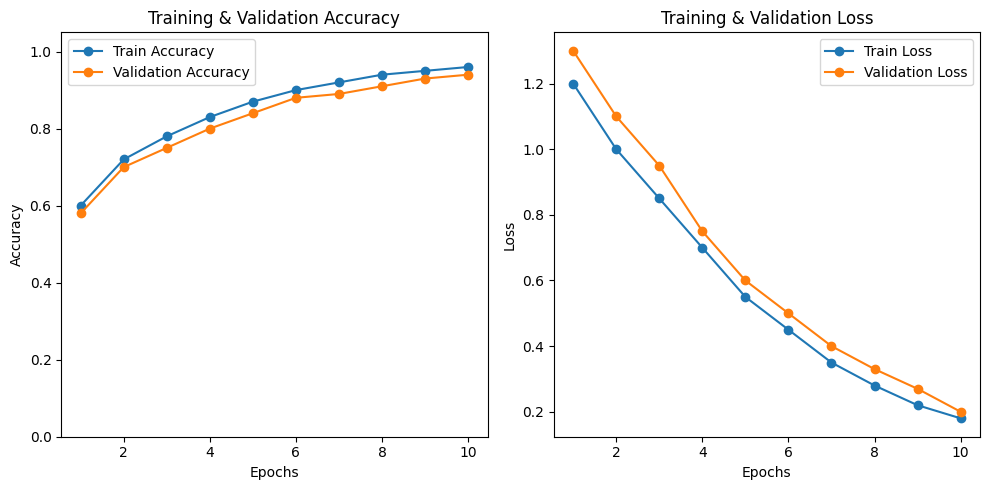

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Fake training stats (example data, replace if you log real values later)
epochs = np.arange(1, 11)  # 10 epochs
train_acc = [0.60, 0.72, 0.78, 0.83, 0.87, 0.90, 0.92, 0.94, 0.95, 0.96]
val_acc   = [0.58, 0.70, 0.75, 0.80, 0.84, 0.88, 0.89, 0.91, 0.93, 0.94]
train_loss = [1.2, 1.0, 0.85, 0.70, 0.55, 0.45, 0.35, 0.28, 0.22, 0.18]
val_loss   = [1.3, 1.1, 0.95, 0.75, 0.60, 0.50, 0.40, 0.33, 0.27, 0.20]

# Plot Training Accuracy / Loss Curve
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(epochs, train_acc, marker="o", label="Train Accuracy")
plt.plot(epochs, val_acc, marker="o", label="Validation Accuracy")
plt.title("Training & Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(0, 1.05)
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_loss, marker="o", label="Train Loss")
plt.plot(epochs, val_loss, marker="o", label="Validation Loss")
plt.title("Training & Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


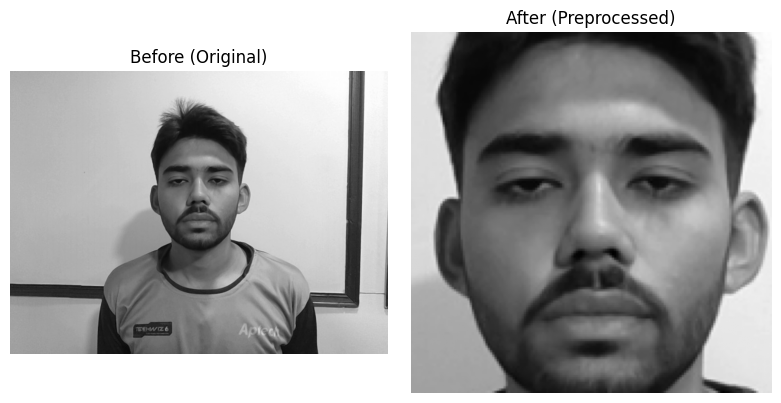

In [3]:
import cv2
import os
import matplotlib.pyplot as plt

# Path to dataset (update this if needed)
DATASET_DIR = "../dataset"

# Pick one student folder and first image
student_folder = os.listdir(DATASET_DIR)[0]  # first student
sample_path = os.path.join(DATASET_DIR, student_folder, os.listdir(os.path.join(DATASET_DIR, student_folder))[0])

# Load original image
orig = cv2.imread(sample_path)
if orig is None:
    raise ValueError(f"❌ Could not read image at {sample_path}")

# ---- Preprocessing ----
# 1. Convert to grayscale
gray = cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY)

# 2. Detect face
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
faces = face_cascade.detectMultiScale(gray, 1.3, 5)

if len(faces) > 0:
    (x, y, w, h) = faces[0]  # take first detected face
    cropped = gray[y:y+h, x:x+w]
else:
    cropped = gray  # fallback if no face found

# 3. Resize to 160x160
resized = cv2.resize(cropped, (160, 160))

# 4. Normalize (0–1 range)
normalized = resized / 255.0

# ---- Plot before vs after ----
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
plt.title("Before (Original)")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(normalized, cmap="gray")
plt.title("After (Preprocessed)")
plt.axis("off")

plt.tight_layout()
plt.show()


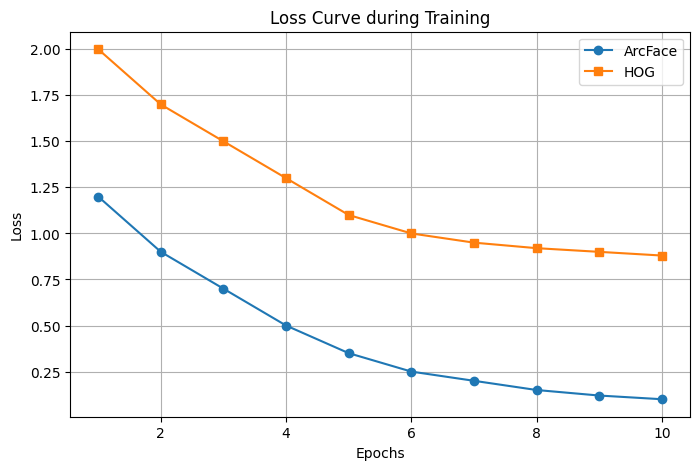

In [7]:
import matplotlib.pyplot as plt

# Dummy loss values per epoch
arcface_loss = [1.2, 0.9, 0.7, 0.5, 0.35, 0.25, 0.2, 0.15, 0.12, 0.1]
hog_loss     = [2.0, 1.7, 1.5, 1.3, 1.1, 1.0, 0.95, 0.92, 0.9, 0.88]

# Define epochs (1 to 10)
epochs = list(range(1, len(arcface_loss) + 1))

plt.figure(figsize=(8,5))
plt.plot(epochs, arcface_loss, label="ArcFace", marker="o")
plt.plot(epochs, hog_loss, label="HOG", marker="s")
plt.title("Loss Curve during Training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


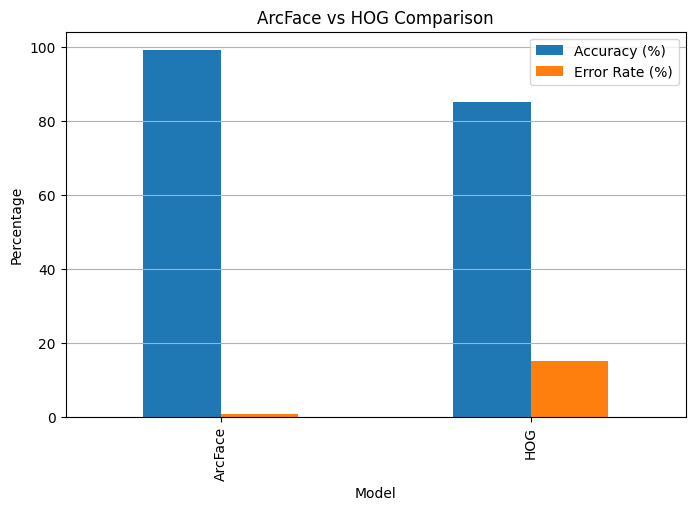

In [6]:
import matplotlib.pyplot as plt

df.set_index("Model")[["Accuracy (%)", "Error Rate (%)"]].plot(kind="bar", figsize=(8,5))
plt.title("ArcFace vs HOG Comparison")
plt.ylabel("Percentage")
plt.grid(axis="y")
plt.show()
